In [53]:
import torch


cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")


if cuda_available:
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    print(f"Device Count: {torch.cuda.device_count()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available: True
Current CUDA Device: 0
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device Count: 1
cuda


In [54]:
import os
import numpy as np
import cv2
import random 


positive_dir = './Dataset/Positive'
negative_dir = './Dataset/Negative'

def load_images_from_directory(directory, limit):
    images = []
    filenames = os.listdir(directory)
    random.shuffle(filenames)
    for filename in filenames[:limit]:
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images


positive_images = load_images_from_directory(positive_dir, 10000)
negative_images = load_images_from_directory(negative_dir, 10000)

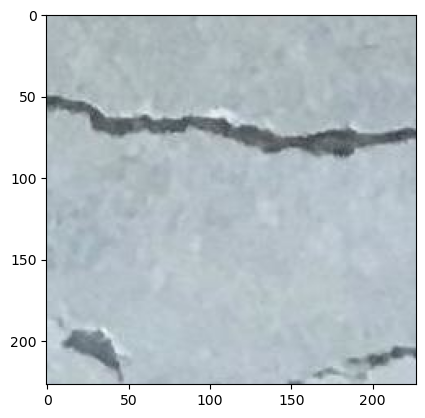

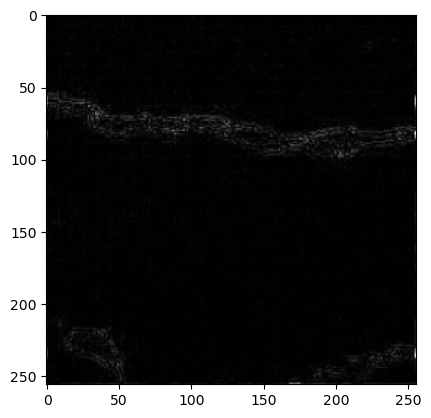

In [55]:
import matplotlib.pyplot as plt

def homomorphic_filtering_cpu(images):
    filtered_images = []
    for img in images:
        try:
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (256, 256))  # Reduced to 32x32

            img_log = np.log1p(np.array(gray, dtype="float32"))

            dft = np.fft.fft2(img_log)
            dft_shift = np.fft.fftshift(dft)

            rows, cols = gray.shape
            crow, ccol = rows // 2, cols // 2
            x, y = np.ogrid[:rows, :cols]
            mask = 1 - np.exp(-((np.sqrt((x - crow)**2 + (y - ccol)**2)**2) / (2 * (60**2))))

            
            dft_shift *= mask
            dft_ishift = np.fft.ifftshift(dft_shift)
            img_back = np.fft.ifft2(dft_ishift)
            img_exp = np.expm1(np.abs(img_back))

           
            filtered_img = cv2.normalize(img_exp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            filtered_images.append(filtered_img)

        except MemoryError as e:
            print(f"Memory error while processing an image: {e}")

    return filtered_images

positive_filtered = homomorphic_filtering_cpu(positive_images)
negative_filtered = homomorphic_filtering_cpu(negative_images)

plt.imshow(positive_images[0])
plt.show()
plt.imshow(positive_filtered[0], cmap='gray')
plt.show()

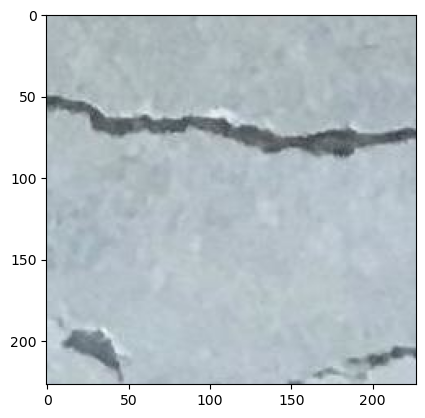

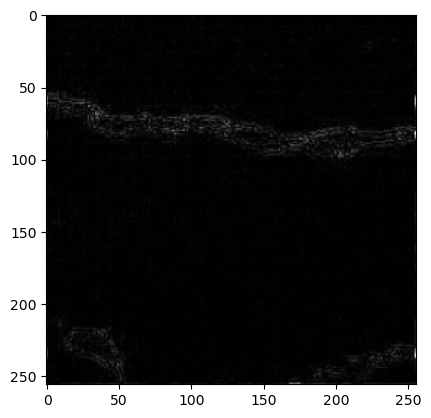

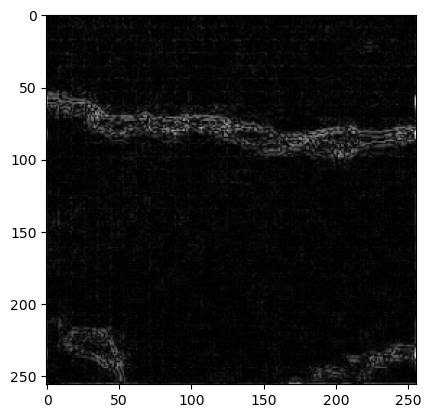

In [56]:

def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_images = [clahe.apply(img) for img in images]
    return enhanced_images

positive_enhanced = apply_clahe(positive_filtered)
negative_enhanced = apply_clahe(negative_filtered)

positive_enhanced = [img for img in positive_enhanced if img is not None]
negative_enhanced = [img for img in negative_enhanced if img is not None]
import matplotlib.pyplot as plt

plt.imshow(positive_images[0])
plt.show()

plt.imshow(positive_filtered[0], cmap='gray')
plt.show()

plt.imshow(positive_enhanced[0], cmap='gray')
plt.show()


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
min_size = min(len(positive_enhanced), len(negative_enhanced))
positive_enhanced = positive_enhanced[:min_size]
negative_enhanced = negative_enhanced[:min_size]
img=[]
for i in positive_enhanced+negative_enhanced:
    img_resized = cv2.resize(i, (128, 128))
    img.append(img_resized)
from torch.utils.data import Dataset , DataLoader
device = torch.device("cpu")
print(device)
from sklearn.model_selection import train_test_split
print(len(img))
X = img
print(len(X))
X = np.array(X) / 255.0  
print(len(X))
X = X.reshape(-1, 1, 128, 128)  
print(len(X))
y = np.array([1] * len(positive_images) + [0] * len(negative_images))
assert len(X) == len(y), f"Inconsistent sample sizes: X has {len(X)}, y has {len(y)}"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


class CrackDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CrackDataset(X_train_tensor, y_train_tensor)
test_dataset = CrackDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class CrackCNN(nn.Module):
    def __init__(self):
        super(CrackCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CrackCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def binarize_and_save_images(loader, model, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for j in range(images.size(0)):
                binary_img = (images[j].cpu().numpy().squeeze() * 255).astype(np.uint8) if predicted[j] == 1 else np.zeros((128, 128), dtype=np.uint8)
                cv2.imwrite(os.path.join(save_dir, f'image_{i * loader.batch_size + j}.png'), binary_img)

binarize_and_save_images(test_loader, model, './BinarizedImages')


cpu
20000
20000
20000
20000
Epoch 1/200, Loss: 0.1264
Epoch 2/200, Loss: 0.0495
Epoch 3/200, Loss: 0.0396
Epoch 4/200, Loss: 0.0312
Epoch 5/200, Loss: 0.0208
Epoch 6/200, Loss: 0.0166
Epoch 7/200, Loss: 0.0129
Epoch 8/200, Loss: 0.0116
Epoch 9/200, Loss: 0.0089
Epoch 10/200, Loss: 0.0072
Epoch 11/200, Loss: 0.0058
Epoch 12/200, Loss: 0.0119
Epoch 13/200, Loss: 0.0024
Epoch 14/200, Loss: 0.0119
Epoch 15/200, Loss: 0.0017
Epoch 16/200, Loss: 0.0046
Epoch 17/200, Loss: 0.0028
Epoch 18/200, Loss: 0.0052
Epoch 19/200, Loss: 0.0063
Epoch 20/200, Loss: 0.0007
Epoch 21/200, Loss: 0.0001
Epoch 22/200, Loss: 0.0000
Epoch 23/200, Loss: 0.0000
Epoch 24/200, Loss: 0.0000
Epoch 25/200, Loss: 0.0000
Epoch 26/200, Loss: 0.0000
Epoch 27/200, Loss: 0.0000
Epoch 28/200, Loss: 0.0000
Epoch 29/200, Loss: 0.0000
Epoch 30/200, Loss: 0.0000
Epoch 31/200, Loss: 0.0000
Epoch 32/200, Loss: 0.0000
Epoch 33/200, Loss: 0.0000
Epoch 34/200, Loss: 0.0000
Epoch 35/200, Loss: 0.0138
Epoch 36/200, Loss: 0.0084
Epoch 37/

In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

img_height, img_width = 128, 128  # Resize images
batch_size = 32
num_epochs = 25

positive_labels = [1] * len(positive_enhanced)
negative_labels = [0] * len(negative_enhanced)


images = positive_enhanced + negative_enhanced
labels = positive_labels + negative_labels

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class CrackDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype('uint8')).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CrackDataset(X_train, y_train, transform=transform)
val_dataset = CrackDataset(X_val, y_val, transform=transform)
test_dataset = CrackDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {100 * correct / total:.2f}%')


model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

def predict_crack(image_array):
    model.eval()
    img = Image.fromarray(image_array.astype('uint8')).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img).item()
    if output > 0.5:
        return "Crack detected"
    else:
        return "No crack detected"

image_array = X_test[0]  
print(predict_crack(image_array))

Epoch [1/25], Loss: 0.1994, Val Loss: 0.1207, Val Accuracy: 95.43%
Epoch [2/25], Loss: 0.1071, Val Loss: 0.0604, Val Accuracy: 98.23%
Epoch [3/25], Loss: 0.0839, Val Loss: 0.1438, Val Accuracy: 94.40%
Epoch [4/25], Loss: 0.0689, Val Loss: 0.0696, Val Accuracy: 97.57%
Epoch [5/25], Loss: 0.0614, Val Loss: 0.0343, Val Accuracy: 99.20%
Epoch [6/25], Loss: 0.0501, Val Loss: 0.0334, Val Accuracy: 99.07%
Epoch [7/25], Loss: 0.0375, Val Loss: 0.0340, Val Accuracy: 99.10%
Epoch [8/25], Loss: 0.0383, Val Loss: 0.0654, Val Accuracy: 97.60%
Epoch [9/25], Loss: 0.0359, Val Loss: 0.0348, Val Accuracy: 99.13%
Epoch [10/25], Loss: 0.0243, Val Loss: 0.0384, Val Accuracy: 99.23%
Epoch [11/25], Loss: 0.0190, Val Loss: 0.0387, Val Accuracy: 98.87%
Epoch [12/25], Loss: 0.0313, Val Loss: 0.0282, Val Accuracy: 99.33%
Epoch [13/25], Loss: 0.0148, Val Loss: 0.0341, Val Accuracy: 99.10%
Epoch [14/25], Loss: 0.0119, Val Loss: 0.0475, Val Accuracy: 98.37%
Epoch [15/25], Loss: 0.0130, Val Loss: 0.0302, Val Accura

In [76]:
model_path = "crack_detection_model.pth"
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to crack_detection_model.pth


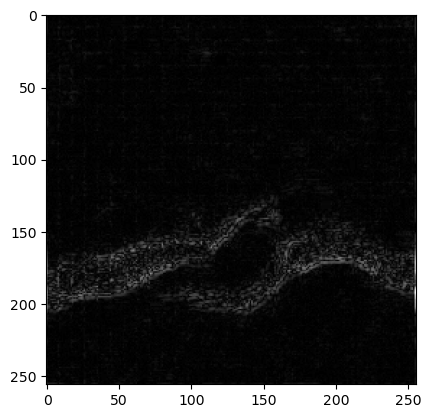

In [77]:
plt.imshow(X_test[0].squeeze(), cmap='gray')
plt.show()